In [10]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Load data
data = pd.read_csv('oil_price_cleaned.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
price = data['Price']

# Split into train and test sets
train_size = int(len(price) * 0.8)
train, test = price[0:train_size], price[train_size:len(price)]

# Regression

ADF Statistic: -9.067698790747345
p-value: 4.387016445887209e-15
Critical Values: {'1%': -3.433665351698571, '5%': -2.8630045337025267, '10%': -2.567549656849864}


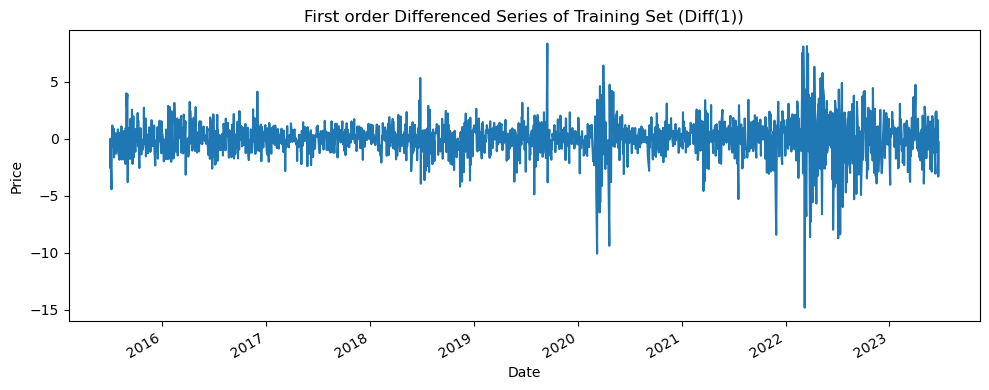

In [3]:
# First-order differencing
diff1_train = train.diff().dropna()

# ADF test
adf_result = adfuller(diff1_train, autolag='AIC')
adf_stat = adf_result[0]
adf_pvalue = adf_result[1]
adf_crit = adf_result[4]

# Print results
print("ADF Statistic:", adf_stat)
print("p-value:", adf_pvalue)
print("Critical Values:", adf_crit)

# Plot the first-order differenced series
plt.figure(figsize=(10,4))
diff1_train.plot()
plt.title("First order Differenced Series of Training Set (Diff(1))")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

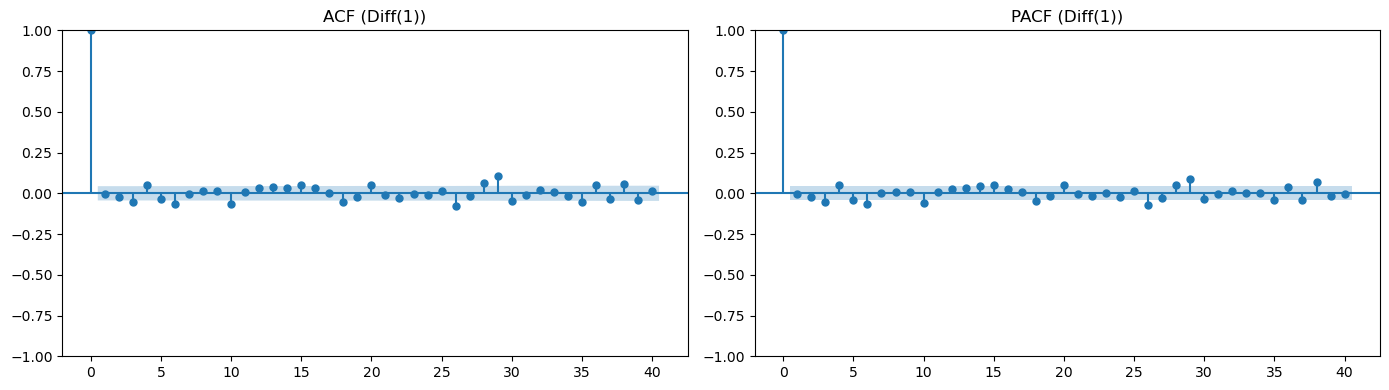

In [4]:
# Plot the ACF and PACF to determine the values of p and q in the ARIMA(p,d,q) model.
# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14,4))

plot_acf(diff1_train, lags=40, ax=axes[0])
axes[0].set_title("ACF (Diff(1))")

plot_pacf(diff1_train, lags=40, ax=axes[1], method='ywm')
axes[1].set_title("PACF (Diff(1))")

plt.tight_layout()
plt.show()

In [5]:
# Iteration to select the best model based on AIC/BIC
p_max = 5   # Maximum order of p, can be adjusted
q_max = 5   # Maximum order of q, can be adjusted

np.random.seed(42)

results = []
for p in range(p_max+1):
    for q in range(q_max+1):
        try:
            model = ARIMA(train, order=(p,1,q))   # d=1
            fitted = model.fit()
            results.append([p, q, fitted.aic, fitted.bic])
        except:
            continue

# Organize results into a table
results_df = pd.DataFrame(results, columns=["p", "q", "AIC", "BIC"])
results_df = results_df.sort_values(by="AIC") # chose AIC

print("Sorted by AIC:")
print(results_df.head(10))

print("Best model (minimum AIC):", results_df.iloc[0])


c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

Sorted by AIC:
    p  q          AIC          BIC
34  5  4  7662.850830  7718.864854
32  5  2  7663.328749  7708.139968
16  2  4  7663.817355  7703.027171
26  4  2  7663.828129  7703.037945
29  4  5  7665.261540  7721.275563
33  5  3  7665.662846  7716.075467
28  4  4  7666.194010  7716.606631
23  3  5  7666.683741  7717.096362
35  5  5  7667.631974  7729.247399
17  2  5  7674.847382  7719.658600
Best model (minimum AIC): p         5.000000
q         4.000000
AIC    7662.850830
BIC    7718.864854
Name: 34, dtype: float64


c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

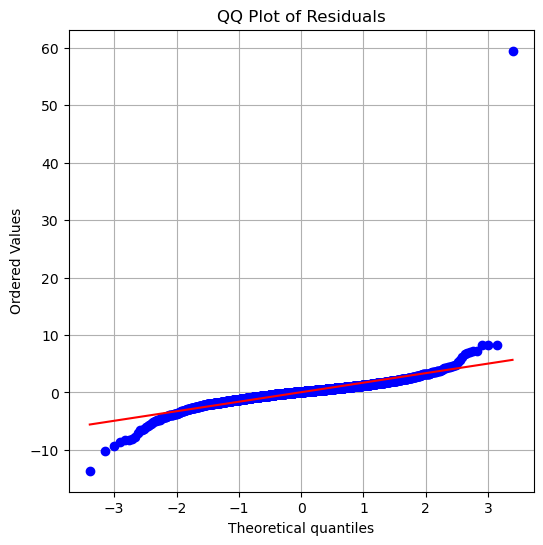

<Figure size 600x400 with 0 Axes>

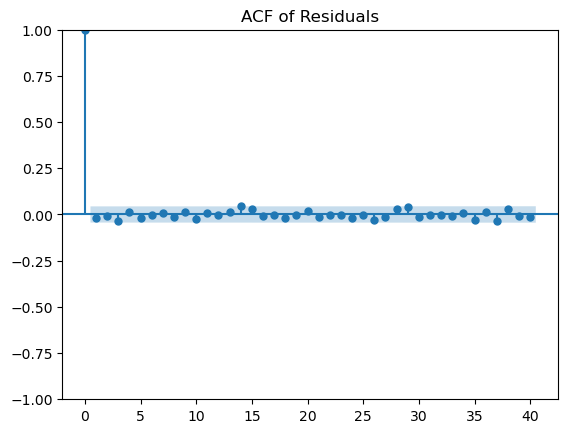

Ljung-Box test results:
      lb_stat  lb_pvalue
10   6.338690   0.786051
20  14.516383   0.803380
30  23.818409   0.780178


In [6]:
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Fit the best model (using the best p,q from previous step)
best_p, best_q = results_df.iloc[0][["p","q"]]
best_model = ARIMA(train, order=(int(best_p),1,int(best_q)))
best_fit = best_model.fit()

# Get residuals
residuals = best_fit.resid

# QQ Plot (normality test)
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()

# Autocorrelation function of residuals (ACF)
plt.figure(figsize=(6,4))
plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

# Ljung-Box test (white noise test)
ljung_res = acorr_ljungbox(residuals, lags=[10,20,30], return_df=True)
print("Ljung-Box test results:")
print(ljung_res)


In [13]:
order = (5, 1, 4)
print(order)

(5, 1, 4)


c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

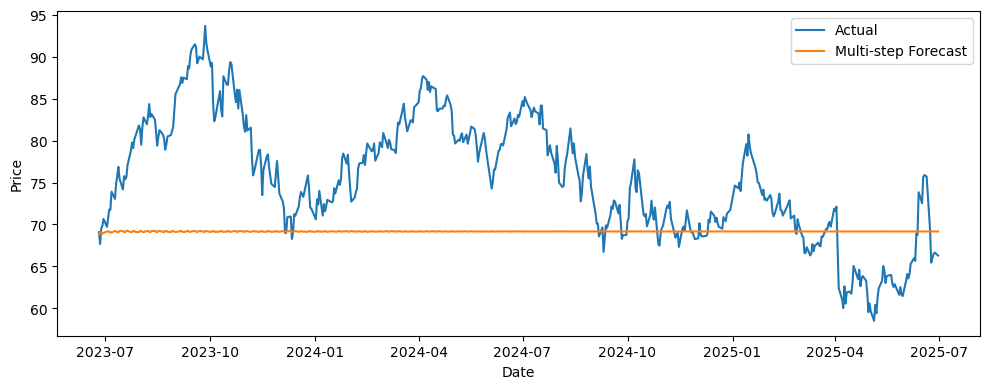

In [8]:
# ========= Multi-step prediction: predict the entire test set length at once =========
def arima_multi_step(train_series, steps, order):
    model = ARIMA(train_series, order=order)
    fit = model.fit()
    # Can also use get_forecast to get confidence intervals
    fc_obj = fit.get_forecast(steps=steps)
    mean_fc = fc_obj.predicted_mean
    conf_int = fc_obj.conf_int(alpha=0.05)  # 95% interval
    mean_fc.index = pd.Index(test.index)    # Align with test set index (to be safe)
    conf_int.index = pd.Index(test.index)
    conf_int.columns = ['lower', 'upper']
    return mean_fc.rename("multi_step_pred"), conf_int

multi_pred, multi_ci = arima_multi_step(train, steps=len(test), order=order)
# Plot
plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label="Actual")
plt.plot(multi_pred.index, multi_pred.values, label="Multi-step Forecast")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.tight_layout(); plt.show()


In [14]:
# ========= Single-step prediction (expanding window) =========
def arima_single_step_expanding(train_series, test_series, order):
    history = train_series.copy()
    preds = []

    for ts, y_true in zip(test_series.index, test_series.values):
        y_hist = history                      # Key for expanding window: don't truncate history
        fit = ARIMA(y_hist, order=order).fit()
        y_hat = float(fit.forecast(steps=1))
        preds.append(y_hat)
        # Use "actual values" to advance
        history = pd.concat([history, pd.Series([y_true], index=[ts])])

    return pd.Series(preds, index=test_series.index, name="single_step_expanding")

single_pred = arima_single_step_expanding(train, test, order)

c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\.conda\envs\hxt\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

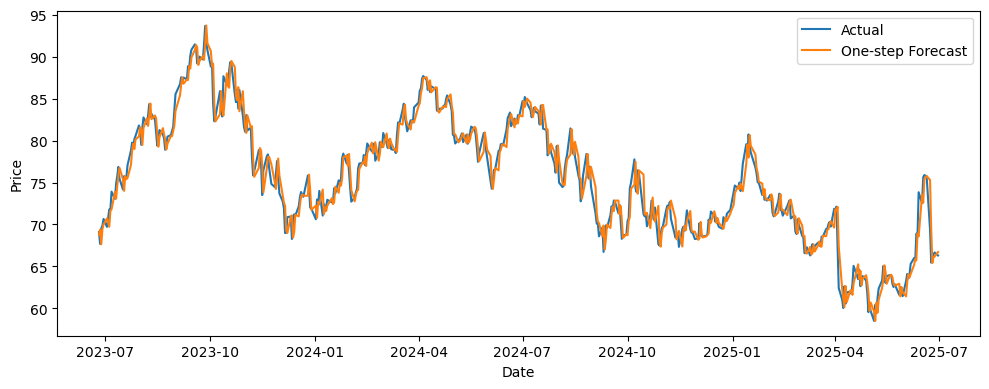

In [16]:
# Plot
plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label="Actual")
plt.plot(single_pred.index, single_pred.values, label="One-step Forecast")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.tight_layout(); plt.show()

In [17]:
def rmse_mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100
    return rmse, mape

rmse_single, mape_single = rmse_mape(test.values, single_pred.values)
rmse_multi,  mape_multi  = rmse_mape(test.values, multi_pred.values)
print(f"[Single-step (Expanding)] RMSE = {rmse_single:.4f}, MAPE = {mape_single:.2f}%")
print(f"[Multi-step] RMSE = {rmse_multi:.4f}, MAPE = {mape_multi:.2f}%")

[Single-step (Expanding)] RMSE = 1.4950, MAPE = 1.55%
[Multi-step] RMSE = 9.5121, MAPE = 9.76%


# Classification

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# ========== Direction Label Construction ==========
last_train = float(train.iloc[-1])

# True direction: p_t - p_{t-1} (using last_train as the first previous value)
y_true_dir = []
prev_true = last_train
for ts, y in test.items():
    y_true_dir.append(1 if (y - prev_true) > 0 else 0)
    prev_true = y
y_true_dir = np.array(y_true_dir, dtype=int)

# Single-step prediction direction: hat_p_t - p_{t-1} (advancing with actual values)
y_pred_single_dir = []
prev_true = last_train
for ts, y_hat in single_pred.items():
    y_pred_single_dir.append(1 if (y_hat - prev_true) > 0 else 0)
    prev_true = float(test.loc[ts])  # advance with actual values
y_pred_single_dir = np.array(y_pred_single_dir, dtype=int)

# Multi-step prediction direction: hat_p_t - hat_p_{t-1} (advancing with predicted values)
y_pred_multi_dir = []
prev_pred = last_train
for ts, y_hat in multi_pred.items():
    y_pred_multi_dir.append(1 if (y_hat - prev_pred) > 0 else 0)
    prev_pred = float(y_hat)         # advance with predicted values
y_pred_multi_dir = np.array(y_pred_multi_dir, dtype=int)

# ========== Print Evaluation (Accuracy and F1 Score) ==========
def print_report(y_true, y_pred, title):
    print("="*60)
    print(title)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

print_report(y_true_dir, y_pred_multi_dir,  "Multi-step (Direction) Evaluation")
print_report(y_true_dir, y_pred_single_dir, "Single-step (Direction) Evaluation")


Multi-step (Direction) Evaluation
Accuracy: 0.4770
F1 Score: 0.4772
Single-step (Direction) Evaluation
Accuracy: 0.5170
F1 Score: 0.5171
